In [3]:
%reload_ext autoreload
%autoreload 2

from imports import *
from gutils import potentials

Choose a potential. Modify the potentials dic in gutils.py to add/change potentials.

In [4]:
potential_name = 'NFWPotential'
potential = potentials[potential_name]['pot']  # get the potential object from gala
vals = potentials[potential_name]['vals']  # get a list of the params we set for the potential

# get the mass density function and the parameters of the potential 
dens_func, params = gu.get_dens_func(potential)

{'m': m, 'r_s': r_s, 'a': a, 'b': b, 'c': c, 'G': G}
-G*m*log(1 + sqrt(z**2/c**2 + y**2/b**2 + x**2/a**2)/r_s)/sqrt(z**2/c**2 + y**2/b**2 + x**2/a**2)


Set the initial configuration of the particles. 

Position of particles are set up according to the initial density distribution coming from the potential. 

Velocities are set up in a more complex way. 
- We assume an angular momentum direction for the galaxy in the z+ direction.
- We get the circular velocity per body using potential.circular_velocity method from gala
- We orient the orbit such that maximized angular momentum in t he z+ direction.  

In [5]:

N = 10000  # Number of particles
S = 100  # Fineness of the density grid
lims = np.array((1,1,1))*1  # 3D limit where you want particles
scale_v_phi = 0.9  # Scale the rotational velocity of the orbits by a factor
scale_R, scale_z = 1, 1   # Noise in local radial and z direction w/ respect to orbit 

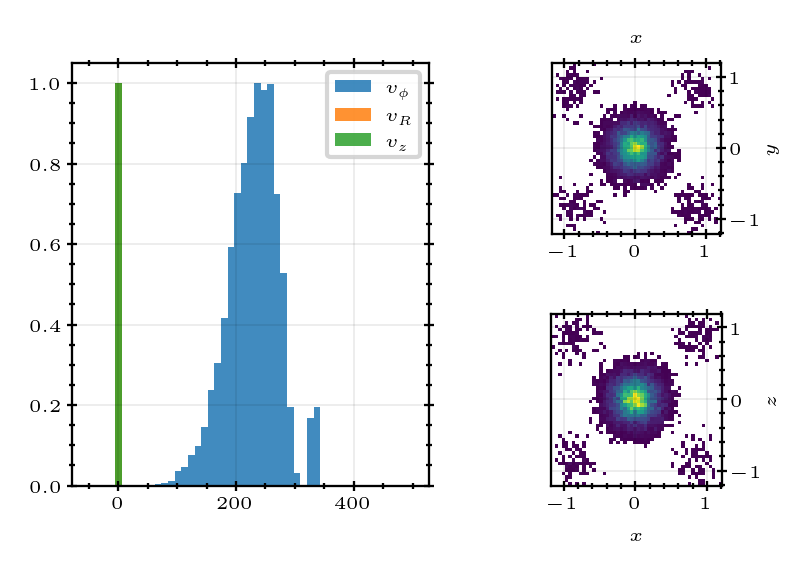

In [14]:
par_vals = vals + [1]
par_dic = dict(zip(params, par_vals))
# Get an array for the density
dens_arr, X, Y, Z = gu.get_dens_arr(dens_func, 
                                    par_dic, 
                                    lims=lims, 
                                    S=S)*u.Msun/(u.kpc)**3

# Get the random positions following the density distribution within lims
pos = gu.get_sample(X, Y, Z, dens_arr, N=N)
pos_norm = pos/np.apply_along_axis(np.linalg.norm, 0, pos)

# Get the velocities
v_phi = potential.circular_velocity(pos)*scale_v_phi
v_R = np.random.normal(0, scale_R, pos.shape[1])
v_z = np.random.normal(0, scale_z, pos.shape[1])
n_vec = np.array([ut.cil_norm(pos[:,i])[0] for i in range(pos.shape[1])]).T
vel = np.array([ut.cil_norm(pos[:,i])[1] for i in range(pos.shape[1])]).T
vel_mag = vel*v_phi + v_R*pos_norm*v_phi.unit + v_z*n_vec*v_phi.unit

# Get the phase space object
phsp = gd.PhaseSpacePosition(pos=pos, vel=vel_mag)

# Take a look at the mass density distribution and velocities
pu.plot_vel_distr(v_phi.value, v_R, v_z, pos, v_lim=500)

Integrate the orbits, and plot and save of the result at each time step. 
We first set some plot parameters.

In [16]:
# Total integration time and time step
TT, dt = 100, 0.1
# Number of batches when computing orbits to avoid memory issues
batches = 100

# Where to save the plots
save_fold = f'../figures/{potential_name}/pngs/'
if not os.path.exists(save_fold):
    os.makedirs(save_fold)

# plot each :step: of the integration
step = 1

facecolor = '#242424'  # background color
scatter_color = 'w'
fig_size = 1080

# Size of scatter points
scatter_size = 5e-2

# limits of the 3D scatter plot and view
lim = np.array((1, 1, 1))*0.55
el, az = 20, 20  # elevation, azimuth

# Some cropping params of the plot
dr = 2.25
x0, y0 = 0.75, 0.75
x1, y1 = x0 + dr, y0 + dr

In [ ]:
H = gp.Hamiltonian(potential)
DT = TT/batches
Ts = np.linspace(0, TT, batches+1)

# Initialize the figure and axes
fig, axs, fs, gs = pu.initialize_3d(fig_size=fig_size, l=lim, 
                                    elev=el, azim=az, facecolor=facecolor)

ax = axs[0][0]
final = int(DT/dt)

# Go through batches
for i, T in enumerate(Ts[:]):
    if i==0:
        init_cond = phsp
    orbits = H.integrate_orbit(init_cond, dt=dt*u.Myr,
                                t1=0*u.Myr, t2=DT*u.Myr)
    xs = orbits.x.value
    ys = orbits.y.value
    zs = orbits.z.value

    vx = orbits.v_x.value
    vy = orbits.v_y.value
    vz = orbits.v_z.value

    init_cond = orbits[-1]

    # Plot each time step
    for jj, j in enumerate(range(0, final, step)):
        jj = int(jj + (i)*final)
        j = int(j*step)
        x_, y_, z_ = xs[j,:], ys[j,:], zs[j,:]
        v = np.sqrt(vx[j,:]**2 + vy[j,:]**2 + vz[j,:]**2)

        scatter = ax.scatter(x_, y_, z_, 
                             #c=v, cmap=cmap, 
                             c='w',
                             s=fs*scatter_size, lw=0.0*fs, alpha=1)

        fig_name = f'render_{jj:04d}.png'
        save_path = save_fold + fig_name

        fig.savefig(save_path, dpi=300, bbox_inches=mpl.transforms.Bbox([[x0, y0], [x1, y1]]))

        plt.close()

        # delete scatter
        scatter.remove()

    print(f'\rbatch {i}/{batches}. T={T:.2f} Myr', end="")

In [ ]:
# make a video out of it
fps = 20
pu.png_to_mp4(save_fold, fps=fps, title=f'video_{fps}')

In [ ]:
# or a gif
fps = 20
pu.png_to_mp4(save_fold, fps=fps, title=f'video_{fps}')